# DNN Classification

In [1]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from labm8 import fs
from labm8 import viz

from keras.models import Sequential
from keras.layers import Input, Embedding, Merge, LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

import clgen
from clgen.atomizer import CharacterAtomizer

Using TensorFlow backend.


In [2]:
seed = 7
np.random.seed(seed)

Methods for wrangling data:

In [3]:
def get_features(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        D["comp"].values,
        D["rational"].values,
        D["mem"].values,
        D["localmem"].values,
        D["coalesced"].values,
        D["transfer"].values,
        D["wgsize"].values,
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T


def get_dynprops(D):
    """ return np array of shape (len(D), 2) """
    return np.array([
        D["transfer"].values,
        D["wgsize"].values
    ]).T


def get_sequences(D, maxlen):
    """ return np array of shape (len(D), maxlen) """
    for row in D["seq"].values:
        assert(len(row) == maxlen)
    data = np.array(D["seq"].values)
    return np.vstack([np.expand_dims(x, axis=0) for x in data])


def get_labels(D):
    """ cpu/gpu to int, return np array of shape (len(D), 1) """
    return np.vstack([np.expand_dims(x, axis=0) for x in D["oracle_enc"]])


def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing """
    assert(sum(split) == 1.0)
    train_split, validation_split, test_split = split
    
    np.random.seed(seed)
    train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]
 
    np.random.seed()  # re-seed RNG
    return train, validation, test

Load dataset:

In [4]:
platform = "nvidia"

# B = pd.read_csv(fs.path("classification/{platform}-benchmarks.csv".format(**vars())))
# B["synthetic_enc"] = [0] * len(B)

# S = pd.read_csv(fs.path("classification/{platform}-clgen.csv".format(**vars())))
# S["synthetic_enc"] = [1] * len(S)

# dataframe = pd.concat((B, S))
# FIXME: tmp
dataframe = pd.read_csv(fs.path("classification/{platform}-clgen.csv".format(**vars())))
dataframe["synthetic"] = ["CLgen"] * len(dataframe)
dataframe["synthetic_enc"] = [1] * len(dataframe)

# oracle encoded
dataframe["oracle_enc"] = [1 if x == "GPU" else 0 for x in dataframe["oracle"].values]

# source code
source_dir = fs.path("classification/kernels")

srcs = []

for row in dataframe["benchmark"].values:
    filename = re.sub("-[A-Z]$", "", row)
    with open(fs.path(source_dir, filename)) as infile:
        src = infile.read()
    srcs.append(src)
    
dataframe["src"] = srcs

print("unique sources", len(set(srcs)))

# encode and pad sequences
atomizer = CharacterAtomizer.from_text(''.join(dataframe["src"].values))

seqs = [atomizer.atomize(seq) for seq in dataframe["src"].values]
seq_length = max(len(s) for s in seqs)
pad_val = atomizer.vocab_size + 1
dataframe["seq"] = list(pad_sequences(seqs, maxlen=seq_length, value=pad_val))
print("vocab size", atomizer.vocab_size)
print("pad val", pad_val)
print("seq length", seq_length)

unique sources 1000
vocab size 68
pad val 69
seq length 658


Features and labels for training:

In [5]:
train, validation, test = get_train_validation_test_splits(dataframe)

x_train_a = get_features(train)
x_train_dynprop = get_dynprops(train)
x_train_b = get_sequences(train, seq_length)
y_train = get_labels(train)

x_val_a = get_features(validation)
x_val_dynprop = get_dynprops(validation)
x_val_b = get_sequences(validation, seq_length)
y_val = get_labels(validation)

x_test_a = get_features(test)
x_test_dynprop = get_dynprops(test)
x_test_b = get_sequences(test, seq_length)
y_test = get_labels(test)

num_features = len(x_train_a[0])
num_dynprop = len(x_train_dynprop[0])
num_classes = np.unique(y_train)
seq_length = len(x_train_b[0])
vocab_size = atomizer.vocab_size + 1  # +1 for pad value

def generate_dummy_data(n, num_features, seq_length):
    """ for testing """
    x_a = np.random.random((n, num_features))
    x_b = np.random.random((n, seq_length))
    y = np.random.random((n, 1))
    return x_a, x_b, y

print("Num features", num_features)
print("Num dynprops", num_dynprop)
print("Num tokens", vocab_size)
print("Seq length", seq_length)
print("Num classes", num_classes)
print("Num instances", len(dataframe))

Num features 11
Num dynprops 2
Num tokens 69
Seq length 658
Num classes [0 1]
Num instances 15919


## Dataset exploration

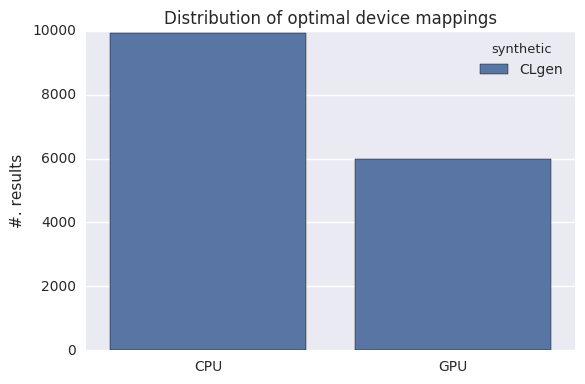

In [6]:
ax = sns.countplot(x="oracle_enc", data=dataframe, hue="synthetic")
plt.title("Distribution of optimal device mappings")
plt.xticks([0, 1], ["CPU", "GPU"])
plt.xlabel("")
plt.ylabel("#. results")
viz.finalise(figsize=(6, 4))

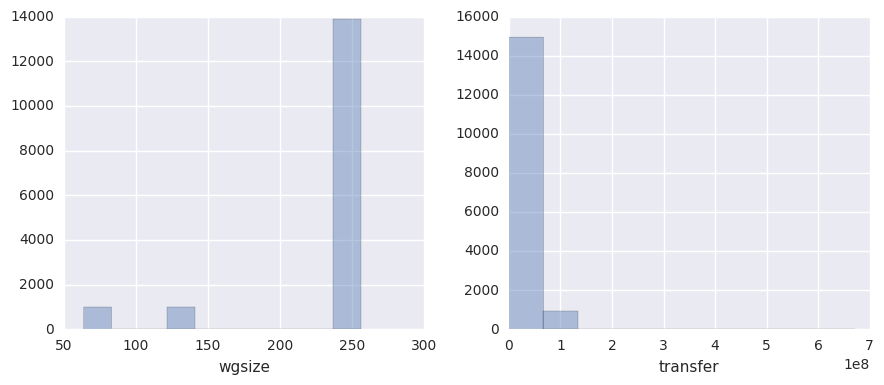

In [7]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["wgsize"], kde=None, bins=10)
plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["transfer"], kde=None, bins=10)
viz.finalise(figsize=(9, 4))

## Source + dynamic props classification

### Baseline model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dynprop_norm (BatchNormalization (None, 11)            44          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 32)            384         dynprop_norm[0][0]               
____________________________________________________________________________________________________
output (Dense)                   (None, 1)             33          dense_1[0][0]                    
Total params: 461
Trainable params: 439
Non-trainable params: 22
____________________________________________________________________________________________________


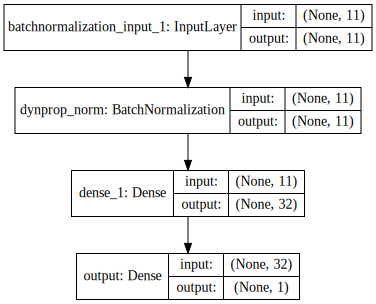

In [8]:
baseline = Sequential()
baseline.add(BatchNormalization(input_shape=(num_features,), name="dynprop_norm"))
baseline.add(Dense(32, input_dim=num_features, activation="relu"))
baseline.add(Dense(1, activation='sigmoid', name="output"))

baseline.compile(loss='binary_crossentropy',
                 optimizer='rmsprop',
                 metrics=['accuracy'])
baseline.summary()

SVG(model_to_dot(baseline, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
np.random.seed(seed)
baseline.fit(x_train_a, y_train,
             nb_epoch=5,
             validation_data=(x_val_a, y_val),
             verbose=1)

baseline_scores = baseline.evaluate(x_test_a, y_test, verbose=0)
print("Accuracy on test data: {:.2%}".format(baseline_scores[1]))

Train on 9559 samples, validate on 3234 samples
Epoch 1/5
9559/9559 [==============================] - 3s - loss: 0.5447 - acc: 0.7205 - val_loss: 0.4866 - val_acc: 0.7783

### Baseline with only dynamic

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dynprop_norm (BatchNormalization (None, 2)             8           batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 32)            96          dynprop_norm[0][0]               
____________________________________________________________________________________________________
output (Dense)                   (None, 1)             33          dense_2[0][0]                    
Total params: 137
Trainable params: 133
Non-trainable params: 4
____________________________________________________________________________________________________


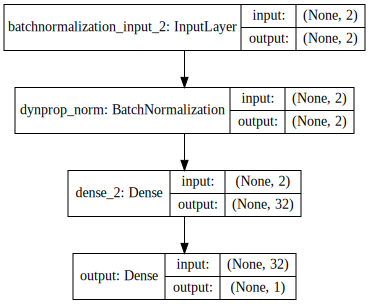

In [10]:
baseline_b = Sequential()
baseline_b.add(BatchNormalization(input_shape=(num_dynprop,), name="dynprop_norm"))
baseline_b.add(Dense(32, input_dim=num_dynprop, activation="relu"))
baseline_b.add(Dense(1, activation='sigmoid', name="output"))

baseline_b.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
baseline_b.summary()

SVG(model_to_dot(baseline_b, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
np.random.seed(seed)
baseline_b.fit(x_train_dynprop, y_train,
               nb_epoch=5,
               validation_data=(x_val_dynprop, y_val),
               verbose=1)

baseline_b_scores = baseline_b.evaluate(x_test_dynprop, y_test, verbose=0)
print("Accuracy on test data: {:.2%}".format(baseline_b_scores[1]))

Train on 9559 samples, validate on 3234 samples
Epoch 1/5
9559/9559 [==============================] - 1s - loss: 0.5336 - acc: 0.7303 - val_loss: 0.4891 - val_acc: 0.8831

### Multi-input model

In [12]:
left = Sequential()
left.add(BatchNormalization(input_shape=(num_features,), name="aux_in"))
# left.add(Dense(num_features, input_dim=num_features, activation="relu"))

embedding_vector_length = 32

right = Sequential()
right.add(Embedding(vocab_size, embedding_vector_length, input_length=seq_length))
right.add(LSTM(32, input_dim=embedding_vector_length, input_length=seq_length))
right.add(BatchNormalization(input_shape=(32,), name="lstm_norm"))

model = Sequential()
model.add(Merge([left, right], mode='concat'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
aux_in (BatchNormalization)      (None, 11)            44                                           
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 658, 32)       2208                                         
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32)            8320                                         
____________________________________________________________________________________________________
lstm_norm (BatchNormalization)   (None, 32)            128                                          
___________________________________________________________________________________________

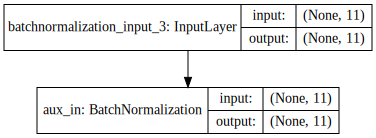

In [24]:
model_to_dot(left, show_shapes=True).write("left.dot")
SVG(model_to_dot(left, show_shapes=True).create(prog='dot', format='svg'))

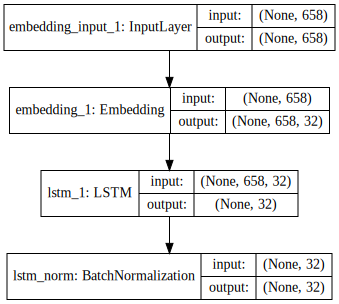

In [25]:
model_to_dot(right, show_shapes=True).write("right.dot")
SVG(model_to_dot(right, show_shapes=True).create(prog='dot', format='svg'))

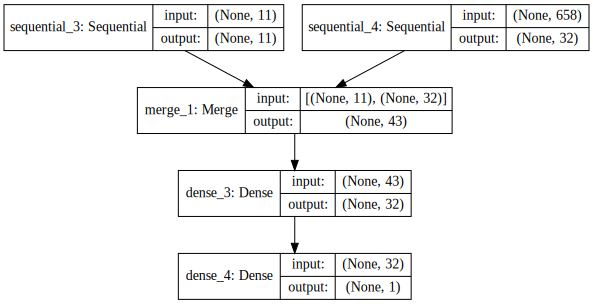

In [23]:
model_to_dot(model, show_shapes=True).write("model.dot")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [16]:
np.random.seed(seed)
model.fit([x_train_a, x_train_b], y_train,
           batch_size=64, nb_epoch=10,
           validation_data=([x_val_a, x_val_b], y_val),
           verbose=1)

scores = model.evaluate([x_test_a, x_test_b], y_test, verbose=0)
print("Accuracy: {:.2%}".format(scores[1]))

Train on 9559 samples, validate on 3234 samples
Epoch 1/10
9559/9559 [==============================] - 138s - loss: 0.6114 - acc: 0.6386 - val_loss: 0.5686 - val_acc: 0.6623

In [17]:
# save or load model:
model.save("model.h5")
# model = load_model('model.h5')